In [1]:
!pip install transformers datasets evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == 

In [2]:

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-09-01 18:16:33.471587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756750593.649635      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756750593.704651      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/sms-spam-collection-dataset/spam.csv


In [3]:
import transformers
print(transformers.__version__)

4.52.4


In [4]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')
df = df[['v1','v2']]   # v1 = label, v2 = text
df = df.rename(columns={'v1':'label','v2':'text'})
df['label'] = df['label'].map({'ham':0, 'spam':1})

In [5]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Train/Test Split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [7]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [8]:
# 2. Tokenization
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

In [10]:
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(['text'])
test_dataset = test_dataset.remove_columns(['text'])

Map:   0%|          | 0/4458 [00:00<?, ? examples/s]

Map:   0%|          | 0/1114 [00:00<?, ? examples/s]

In [11]:
# 3. Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# 4. Training Setup
accuracy = evaluate.load("accuracy")

In [13]:
def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(-1)
    return accuracy.compute(predictions=preds, references=labels)

In [51]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",     # log every X steps
    logging_steps=50,            # adjust as needed
    report_to="none",            # disables wandb
)

In [52]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_36/1377821198.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [53]:
train_result = trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.220180,0.987433
2,0.000000,0.223160,0.987433
3,0.000000,0.225985,0.987433
4,0.000000,0.226805,0.987433
5,0.000000,0.226613,0.987433


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [39]:
import matplotlib.pyplot as plt

In [54]:
# Grab logs from Trainer state
logs = trainer.state.log_history

# Separate training & evaluation logs
train_loss = [x['loss'] for x in logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]

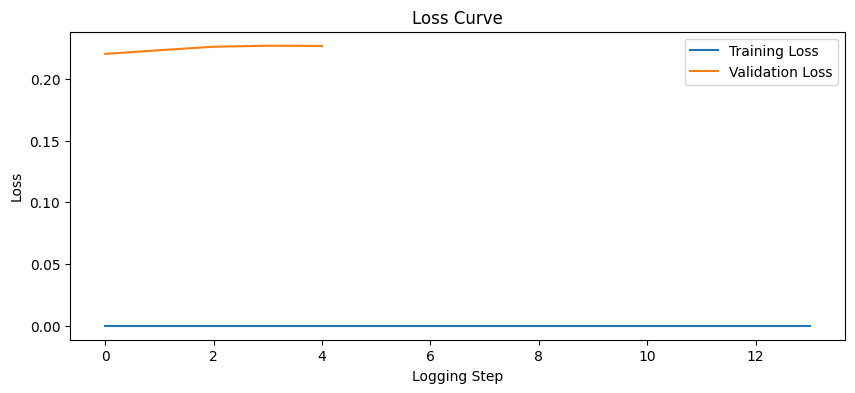

In [55]:
# Plot training + eval loss
plt.figure(figsize=(10,4))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Logging Step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

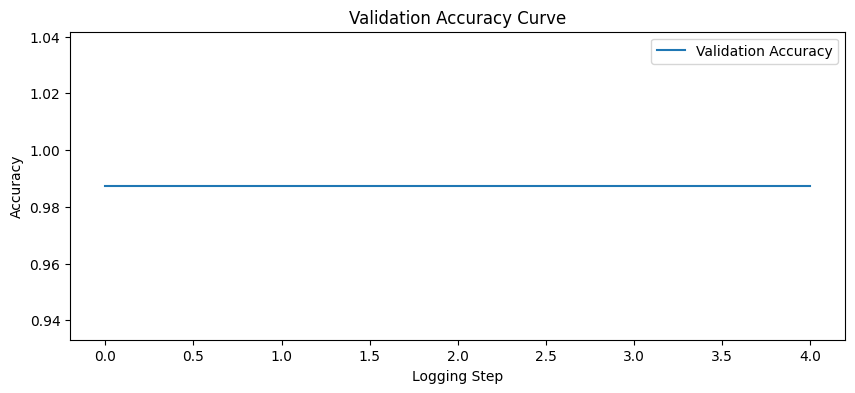

In [56]:
# Plot accuracy
plt.figure(figsize=(10,4))
plt.plot(eval_acc, label='Validation Accuracy')
plt.xlabel('Logging Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()

In [57]:
plt.savefig("loss_curve.png")


<Figure size 640x480 with 0 Axes>

In [58]:
plt.savefig("accuracy_curve.png")

<Figure size 640x480 with 0 Axes>

In [59]:
# 6. Save Model
model.save_pretrained("./sms_spam_model")


In [60]:
tokenizer.save_pretrained("./sms_spam_model")

('./sms_spam_model/tokenizer_config.json',
 './sms_spam_model/special_tokens_map.json',
 './sms_spam_model/vocab.txt',
 './sms_spam_model/added_tokens.json',
 './sms_spam_model/tokenizer.json')

In [61]:
import shutil

shutil.make_archive("sms_spam_model", 'zip', "./sms_spam_model")

'/kaggle/working/sms_spam_model.zip'